In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import os
import random
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from torchsummary import summary
from PIL import Image
import io

In [3]:
# Define the train and test directories
train_dir = './AppleLeavesDataset/train'
test_dir = './AppleLeavesDataset/valid'

In [4]:
for folder in os.listdir(train_dir):
  count=0
  dir = str(train_dir + '/' + folder);
  for img in os.listdir(dir):
    count+=1
  print(f'No of files in the {folder} is {count}')

No of files in the Apple___Apple_scab is 2016
No of files in the Apple___Black_rot is 1987
No of files in the Apple___Cedar_apple_rust is 1760
No of files in the Apple___healthy is 2008


In [5]:
# Define the class names
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']

In [6]:
# Function to view images
def view_image(target_dir, target_class):
    target_folder = os.path.join(target_dir, target_class)
    random_img = random.choice(os.listdir(target_folder))
    img = cv2.imread(os.path.join(target_folder, random_img))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(target_class)
    plt.axis('off')
    print(f'image shape:{img.shape}')
    return img

image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)
image shape:(256, 256, 3)


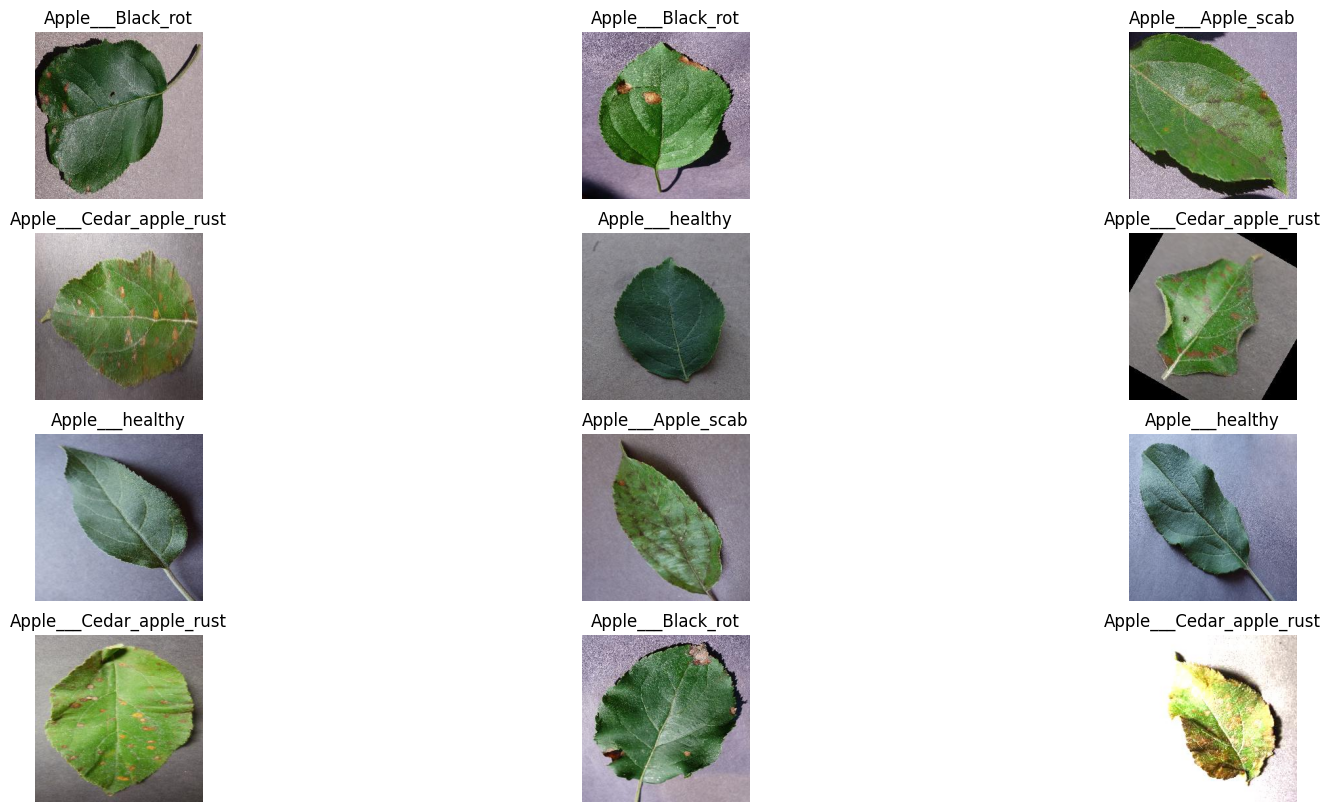

In [7]:
plt.figure(figsize=(20,10))
for i in range(12):
  plt.subplot(4, 3, i+1)
  class_name = random.choice(class_names)
  view_image(target_dir=train_dir, target_class=class_name)

In [8]:
def train_valid_loaders(train_dir, test_dir, batch_size=20):
    # Define transformations for training and validation sets
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    valid_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [9]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Initialize the model, loss function, and optimizer on the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Print the summary
summary(model, (3, 256, 256))  # Assuming input shape is (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]           3,584
         MaxPool2d-2        [-1, 128, 128, 128]               0
            Conv2d-3        [-1, 128, 128, 128]         147,584
         MaxPool2d-4          [-1, 128, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          73,792
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
         MaxPool2d-8           [-1, 64, 16, 16]               0
           Flatten-9                [-1, 16384]               0
          Dropout-10                [-1, 16384]               0
           Linear-11                  [-1, 512]       8,389,120
           Linear-12                    [-1, 4]           2,052
Total params: 8,653,060
Trainable params: 8,653,060
Non-trainable params: 0
---------------------------

In [12]:
# Function to train the model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to GPU
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the test images: {100 * correct / total}%')

In [175]:
# # Train the model
# train_loader, test_loader = train_valid_loaders(train_dir, test_dir)
# train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Loss: 0.4450133025531291
Accuracy of the network on the test images: 94.85331960885229%
Epoch [2/5], Loss: 0.13319316294863054
Accuracy of the network on the test images: 91.04477611940298%
Epoch [3/5], Loss: 0.1116912290989601
Accuracy of the network on the test images: 96.29439011837366%
Epoch [4/5], Loss: 0.06788527214958615
Accuracy of the network on the test images: 97.58106021616058%
Epoch [5/5], Loss: 0.05044152311152724
Accuracy of the network on the test images: 97.83839423571796%


In [179]:
# path = 'my_model.pth'
# # Save the model
# torch.save(model.state_dict(), path)

In [13]:
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

CNNModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [15]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Provide the path to your image file
image_path = './AppleLeavesDataset/valid/Apple___Cedar_apple_rust/04da297e-5238-41b1-a8a0-0c87c6c2f21f___FREC_C.Rust 4394_new30degFlipLR.JPG'

# Read the image file and store its content in 'file_content'
with open(image_path, 'rb') as file:
    file_content = file.read()

# Load image and preprocess
img = Image.open(io.BytesIO(file_content)).resize((256, 256))
img = transform(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Perform inference
with torch.no_grad():
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)
if predicted.item() == 0:
    print('Apple___Apple_scab')
elif predicted.item() == 1:
    print('Apple___Black_rot')
elif predicted.item() == 2:
    print('Apple___Cedar_apple_rust')
else:
    print('Apple___healthy')

Apple___Cedar_apple_rust
